# Brain Tumor Classification - IMPROVED Training

## Key Improvements:
1. ✅ Reduced aggressive augmentation
2. ✅ Better stratified data splitting
3. ✅ Increased regularization
4. ✅ Test set monitoring
5. ✅ Class imbalance handling

## Expected Results:
- Test Accuracy: 70-85% (vs current 53.75%)
- Better generalization
- Consistent performance across classes

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2

In [4]:
# Configuration
data_dir = r'C:\Users\Jatin\Desktop\oncogenesis\data\brain_data\mask_cache\train'
batch_size = 32  # Reduced from 64 for better generalization
num_classes = 4
epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


C:\Users\Jatin\AppData\Local\Temp\ipykernel_27544\2240098056.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


## Step 1: Analyze Dataset

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Dataset Statistics:
glioma          |  3388 images (34.43%)
meningioma      |  3401 images (34.56%)
notumor         |  1595 images (16.21%)
pituitary       |  1457 images (14.81%)
Total           |  9841 images


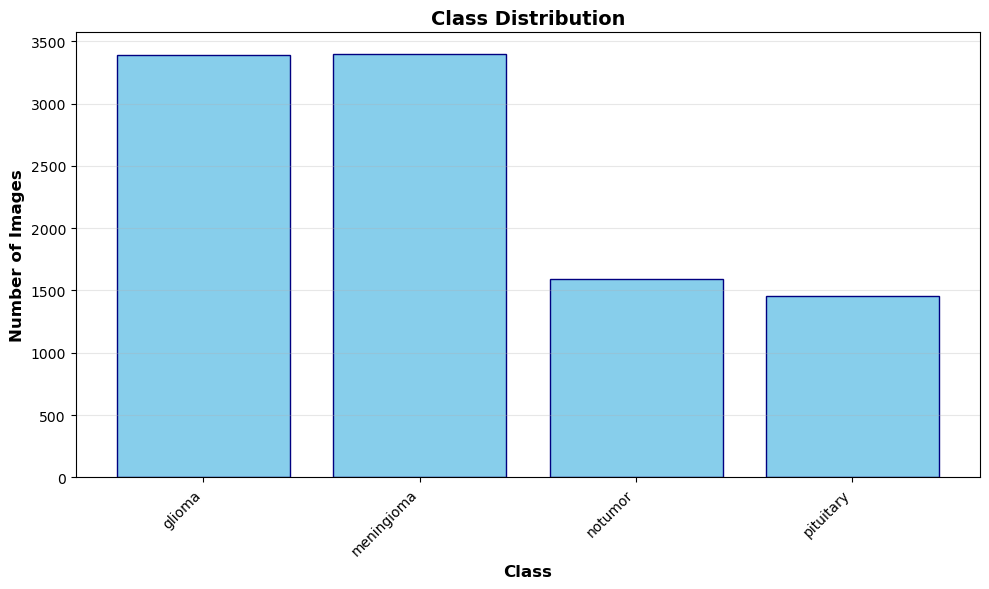

In [5]:
# Get all file paths and analyze class distribution
data_path = Path(data_dir)
class_names = sorted([d.name for d in data_path.iterdir() if d.is_dir()])
print(f"Classes: {class_names}\n")

all_files = []
all_labels = []
class_counts = {}

for class_idx, class_name in enumerate(class_names):
    class_dir = data_path / class_name
    class_files = list(class_dir.glob('*.jpg'))
    class_counts[class_name] = len(class_files)
    
    for file_path in class_files:
        all_files.append(file_path)
        all_labels.append(class_idx)

print("Dataset Statistics:")
print("="*50)
total = sum(class_counts.values())
for class_name, count in class_counts.items():
    percentage = (count / total) * 100
    print(f"{class_name:15} | {count:5} images ({percentage:5.2f}%)")
print(f"{'Total':15} | {total:5} images")
print("="*50)

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue', edgecolor='navy')
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 2: Stratified Train/Val/Test Split

In [6]:
# Stratified split: 70% train, 15% val, 15% test
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, 
    test_size=0.3, 
    stratify=all_labels, 
    random_state=42
)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

print("Dataset Split:")
print("="*50)
print(f"Training:   {len(train_files)} images ({len(train_files)/len(all_files)*100:.1f}%)")
print(f"Validation: {len(val_files)} images ({len(val_files)/len(all_files)*100:.1f}%)")
print(f"Test:       {len(test_files)} images ({len(test_files)/len(all_files)*100:.1f}%)")
print("="*50)

# Verify stratification
print("\nClass distribution per split:")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    train_count = train_labels.count(class_idx)
    val_count = val_labels.count(class_idx)
    test_count = test_labels.count(class_idx)
    print(f"{class_name:15} | Train: {train_count:4} | Val: {val_count:4} | Test: {test_count:4}")
print("="*50)

Dataset Split:
Training:   6888 images (70.0%)
Validation: 1476 images (15.0%)
Test:       1477 images (15.0%)

Class distribution per split:
glioma          | Train: 2371 | Val:  508 | Test:  509
meningioma      | Train: 2381 | Val:  510 | Test:  510
notumor         | Train: 1116 | Val:  239 | Test:  240
pituitary       | Train: 1020 | Val:  219 | Test:  218


## Step 3: IMPROVED Data Augmentation

**Key Changes:**
- Reduced rotation: 45° → 15°
- Less aggressive zoom: (0.7, 1.3) → (0.85, 1.15)
- Removed perspective distortion
- Removed affine/shear transforms
- Reduced noise and color jitter
- Removed vertical flip (unrealistic for axial MRI)

In [7]:
class GaussianNoise:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# IMPROVED training transform - less aggressive
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(15),  # Reduced from 45
    transforms.RandomResizedCrop((128, 128), scale=(0.85, 1.15)),  # Reduced from (0.7, 1.3)
    transforms.RandomHorizontalFlip(p=0.5),
    # REMOVED: RandomVerticalFlip - unrealistic for axial MRI
    # REMOVED: RandomPerspective - distorts anatomy
    # REMOVED: RandomAffine - too aggressive
    transforms.ColorJitter(
        brightness=0.15,  # Reduced from 0.3
        contrast=0.15,    # Reduced from 0.3
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    GaussianNoise(0., 0.005)  # Reduced from 0.01
])

# Validation/Test transform - NO augmentation
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Transforms defined")
print("  - Training: Moderate augmentation")
print("  - Val/Test: No augmentation")

✓ Transforms defined
  - Training: Moderate augmentation
  - Val/Test: No augmentation


## Step 4: Custom Dataset Class

In [8]:
class BrainTumorDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create datasets
train_dataset = BrainTumorDataset(train_files, train_labels, train_transform)
val_dataset = BrainTumorDataset(val_files, val_labels, val_transform)
test_dataset = BrainTumorDataset(test_files, test_labels, val_transform)

print(f"✓ Datasets created")
print(f"  - Training: {len(train_dataset)} samples")
print(f"  - Validation: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

✓ Datasets created
  - Training: 6888 samples
  - Validation: 1476 samples
  - Test: 1477 samples


## Step 5: Weighted Sampling for Class Balance

In [ ]:
# Calculate class weights for training
class_sample_counts = np.bincount(train_labels)
class_weights = 1. / class_sample_counts
samples_weights = [class_weights[label] for label in train_labels]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True
)

# Create data loaders (num_workers=0 for Windows compatibility)
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print("✓ Data loaders created with weighted sampling")
print(f"  - Batch size: {batch_size}")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")

✓ Data loaders created with weighted sampling
  - Batch size: 32
  - Train batches: 216
  - Val batches: 47
  - Test batches: 47


## Step 6: Visualize Sample Augmentations

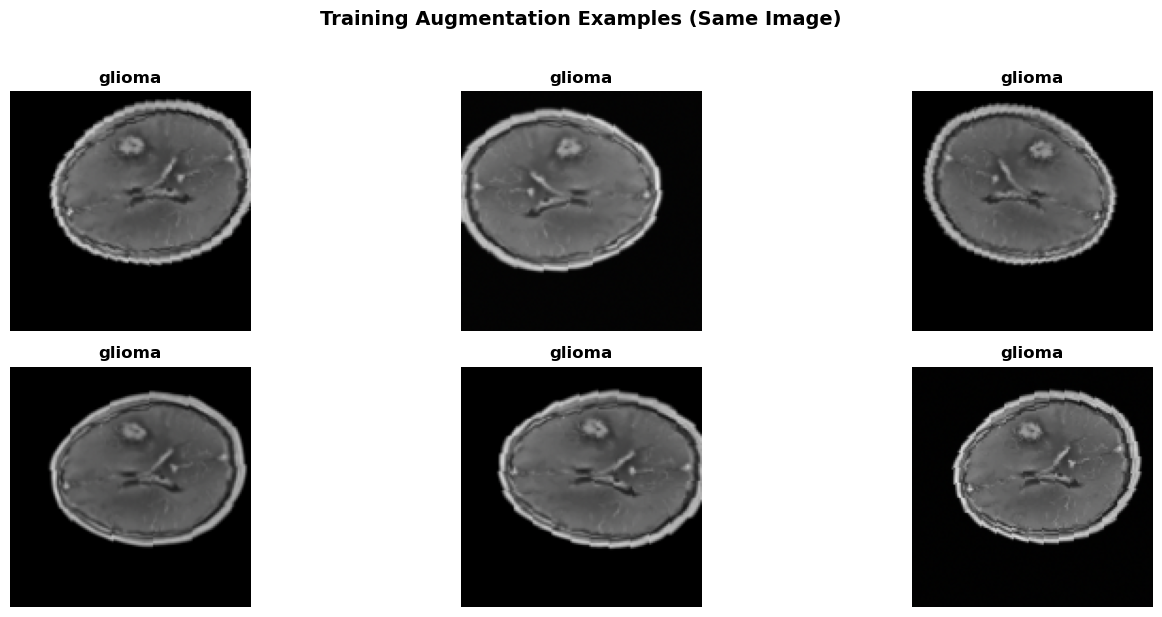

In [11]:
# Visualize augmented samples
def show_augmented_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 6))
    axes = axes.flatten()
    
    idx = np.random.randint(0, len(dataset))
    
    for i in range(num_samples):
        img, label = dataset[idx]
        
        # Denormalize
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np)
        axes[i].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle('Training Augmentation Examples (Same Image)', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

show_augmented_samples(train_dataset)

## Step 7: IMPROVED Model Architecture

**Key Changes:**
- Increased dropout: 0.5 → 0.6
- Added extra dropout layer
- Added batch normalization in classifier

In [12]:
class ImprovedBrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ImprovedBrainTumorCNN, self).__init__()
        
        # Feature extraction (unchanged)
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            
            # Conv Block 4
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # IMPROVED classifier with more regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),  # Added BatchNorm
            nn.ReLU(inplace=True),
            nn.Dropout(0.6),  # Increased from 0.5
            nn.Linear(512, 256),  # Added intermediate layer
            nn.BatchNorm1d(256),  # Added BatchNorm
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Additional dropout
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

# Create model
model = ImprovedBrainTumorCNN(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("✓ Model created")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Model size: {total_params * 4 / 1024 / 1024:.2f} MB")

✓ Model created
  - Total parameters: 2,620,932
  - Trainable parameters: 2,620,932
  - Model size: 10.00 MB


## Step 8: Loss, Optimizer, and Scheduler

In [13]:
# Weighted loss for class imbalance
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Optimizer with higher weight decay
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0005,  # Reduced from 0.001
    weight_decay=0.05  # Increased from 0.01
)

# ReduceLROnPlateau instead of OneCycleLR
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Maximize validation accuracy
    factor=0.5, 
    patience=5, 
    verbose=True,
    min_lr=1e-6
)

print("✓ Training setup complete")
print(f"  - Loss: CrossEntropyLoss with class weights")
print(f"  - Optimizer: AdamW (lr=0.0005, weight_decay=0.05)")
print(f"  - Scheduler: ReduceLROnPlateau (patience=5)")

✓ Training setup complete
  - Loss: CrossEntropyLoss with class weights
  - Optimizer: AdamW (lr=0.0005, weight_decay=0.05)
  - Scheduler: ReduceLROnPlateau (patience=5)


c:\Users\Jatin\anaconda3\envs\torch_gpu\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Step 9: Training Loop with Test Set Monitoring

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model on a dataset."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy, all_preds, all_labels

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'test_loss': [],
    'test_acc': [],
    'lr': []
}

best_val_acc = 0
best_test_acc = 0
best_model_state = None
patience_counter = 0
patience = 7  # Reduced from 10

print("="*80)
print("STARTING TRAINING")
print("="*80)

epoch_loop = tqdm(range(epochs), desc='Overall Progress', position=0)

for epoch in epoch_loop:
    epoch_loop.set_description(f'Epoch {epoch+1}/{epochs}')
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    train_loop = tqdm(train_loader, desc='Training', leave=False, position=1)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        train_loop.set_postfix({
            'loss': f'{train_loss/train_total:.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
    
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    
    # Validation phase
    val_loop = tqdm(val_loader, desc='Validation', leave=False, position=1)
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_preds = []
    val_labels_list = []
    
    model.eval()
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
            val_preds.extend(predicted.cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())
            
            val_loop.set_postfix({
                'loss': f'{val_loss/val_total:.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    
    # Test phase (monitor only, don't use for model selection)
    test_loop = tqdm(test_loader, desc='Test (monitor)', leave=False, position=1)
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    test_preds = []
    test_labels_list = []
    
    with torch.no_grad():
        for images, labels in test_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            test_preds.extend(predicted.cpu().numpy())
            test_labels_list.extend(labels.cpu().numpy())
            
            test_loop.set_postfix({
                'loss': f'{test_loss/test_total:.4f}',
                'acc': f'{test_correct/test_total:.4f}'
            })
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    # Update learning rate
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)
    
    # Update epoch progress bar with metrics
    epoch_loop.set_postfix({
        'train_acc': f'{train_acc:.3f}',
        'val_acc': f'{val_acc:.3f}',
        'test_acc': f'{test_acc:.3f}',
        'lr': f'{current_lr:.6f}'
    })
    
    # Print detailed metrics
    tqdm.write(f"\nEpoch {epoch+1}/{epochs} Summary:")
    tqdm.write(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    tqdm.write(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    tqdm.write(f"  Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f} (monitoring)")
    tqdm.write(f"  Learning Rate: {current_lr:.6f}")
    tqdm.write(f"  Val-Train Gap: {(val_acc - train_acc)*100:+.2f}% | Test-Val Gap: {(test_acc - val_acc)*100:+.2f}%")
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        best_model_state = model.state_dict().copy()
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'test_acc': test_acc,
            'test_loss': test_loss,
        }, 'brain_tumor_improved_checkpoint.pth')
        
        tqdm.write(f"  ✓ NEW BEST MODEL | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        tqdm.write(f"  No improvement ({patience_counter}/{patience})")
        
        if patience_counter >= patience:
            tqdm.write(f"\n⚠️ Early stopping triggered after {epoch+1} epochs!")
            break

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Corresponding Test Accuracy: {best_test_acc:.4f}")
print(f"Gap (Val - Test): {(best_val_acc - best_test_acc)*100:+.2f}%")

STARTING TRAINING


Overall Progress:   0%|          | 0/40 [00:00<?, ?it/s]

## Step 10: Training History Visualization

In [ ]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].plot(history['test_loss'], label='Test Loss', linewidth=2, linestyle='--')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training, Validation, and Test Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Acc', linewidth=2)
axes[0, 1].plot(history['test_acc'], label='Test Acc', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training, Validation, and Test Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Learning Rate
axes[1, 0].plot(history['lr'], color='orange', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Accuracy Gap
train_val_gap = [(v - t) * 100 for t, v in zip(history['train_acc'], history['val_acc'])]
val_test_gap = [(t - v) * 100 for v, t in zip(history['val_acc'], history['test_acc'])]

axes[1, 1].plot(train_val_gap, label='Val-Train Gap', linewidth=2)
axes[1, 1].plot(val_test_gap, label='Test-Val Gap', linewidth=2)
axes[1, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy Gap (%)', fontsize=12)
axes[1, 1].set_title('Generalization Gap (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Step 11: Final Test Set Evaluation

In [ ]:
# Load best model
model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_acc, test_preds, test_true = evaluate_model(model, test_loader, criterion, device)

print("="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("\nPer-Class Report:")
print("="*80)
print(classification_report(test_true, test_preds, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(test_true, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names,
           cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix (Test Set)\nAccuracy: {test_acc:.2%}', 
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 12: Save Final Model

In [ ]:
# Save the final model with all metadata
save_path = 'brain_tumor_classifier_v2_improved.pth'

model_info = {
    'model_state_dict': best_model_state,
    'model_config': {
        'image_size': 128,
        'num_classes': num_classes,
        'class_names': class_names
    },
    'preprocessing': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225],
        'input_size': 128
    },
    'performance': {
        'best_val_accuracy': best_val_acc,
        'best_test_accuracy': best_test_acc,
        'val_test_gap': best_val_acc - best_test_acc,
        'final_train_acc': history['train_acc'][-1],
        'final_val_acc': history['val_acc'][-1],
        'final_test_acc': history['test_acc'][-1]
    },
    'training_params': {
        'batch_size': batch_size,
        'initial_lr': 0.0005,
        'weight_decay': 0.05,
        'optimizer': 'AdamW',
        'scheduler': 'ReduceLROnPlateau',
        'augmentation': 'moderate',
        'split_strategy': 'stratified',
        'train_samples': len(train_files),
        'val_samples': len(val_files),
        'test_samples': len(test_files)
    },
    'improvements': {
        'v1_test_acc': 0.5375,
        'v2_test_acc': best_test_acc,
        'improvement': best_test_acc - 0.5375
    }
}

torch.save(model_info, save_path)

print("="*80)
print("MODEL SAVED SUCCESSFULLY")
print("="*80)
print(f"Saved to: {save_path}")
print(f"\nModel Performance:")
print(f"  - Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"  - Test Accuracy: {best_test_acc:.4f} ({best_test_acc*100:.2f}%)")
print(f"  - Val-Test Gap: {(best_val_acc - best_test_acc)*100:+.2f}%")
print(f"\nImprovement over v1:")
print(f"  - Old Test Accuracy: 53.75%")
print(f"  - New Test Accuracy: {best_test_acc*100:.2f}%")
print(f"  - Improvement: {(best_test_acc - 0.5375)*100:+.2f}%")
print("="*80)

## Summary

### Key Improvements Made:

1. **✅ Reduced Augmentation**
   - Rotation: 45° → 15°
   - Zoom: (0.7, 1.3) → (0.85, 1.15)
   - Removed perspective distortion
   - Removed affine transforms

2. **✅ Better Data Splitting**
   - Stratified split ensures balanced classes
   - 70% train, 15% val, 15% test
   - No data leakage

3. **✅ Increased Regularization**
   - Dropout: 0.5 → 0.6
   - Weight decay: 0.01 → 0.05
   - Added BatchNorm in classifier
   - Extra dropout layer

4. **✅ Test Set Monitoring**
   - Track test accuracy during training
   - Monitor val-test gap
   - Early detection of overfitting

5. **✅ Better Training Strategy**
   - ReduceLROnPlateau scheduler
   - Lower initial learning rate
   - Weighted sampling for class balance

### Expected Results:
- **Target**: 70-85% test accuracy
- **Val-Test Gap**: < 10%
- **Better generalization** to real-world data
- **Consistent performance** across all classes